In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='~/.datasets')
train_data = mnist.data[:60000].copy().astype(np.float32) / 255
train_labels = mnist.target[:60000].copy().astype(np.int64)
test_data = mnist.data[60000:70000].copy().astype(np.float32) / 255
test_labels = mnist.target[60000:70000].copy().astype(np.int64)

In [3]:
from tqdm import tqdm

In [30]:
def train(train_data, train_labels, test_data, test_labels, layers = 1, hdim = None,
          activation = None, criterion = torch.nn.CrossEntropyLoss, biases = True, epochs = 5):
    batchsize = 64
    indim = train_data.shape[1]
    outdim = np.unique(train_labels).shape[0]

    modules = []
    for i in xrange(layers):
        if i == 0:
            dim1 = indim
        else:
            dim1 = hdim
        if i == layers - 1:
            dim2 = outdim
        else:
            dim2 = hdim
        modules.append(torch.nn.Linear(dim1, dim2, bias = biases))
        if activation != None and i != layers - 1:
            modules.append(activation())
    model = torch.nn.Sequential(*modules)

    orig_train_labels = train_labels
    orig_test_labels = test_labels
    if (criterion == torch.nn.MSELoss):
        new_train_labels = np.zeros((train_data.shape[0], outdim))
        for i, label in enumerate(train_labels):
            new_train_labels[i, label] = 1
        train_labels = new_train_labels.astype(np.float32)
        
        new_test_labels = np.zeros((test_data.shape[0], outdim))
        for i, label in enumerate(test_labels):
            new_test_labels[i, label] = 1
        test_labels = new_test_labels.astype(np.float32)
    compute_loss = criterion()

    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters = int(np.ceil(float(train_data.shape[0]) / batchsize))
    losses = np.zeros((epochs, 2))
    norms = np.zeros((epochs, 2))
    acc = np.zeros((epochs, 2))
    prec = np.zeros((epochs, 2))
    rec = np.zeros((epochs, 2))
    for ep in xrange(epochs):
        p = np.random.permutation(len(train_labels))
        shuf_data = train_data[p, :]
        shuf_labels = train_labels[p]
        for i in tqdm(xrange(iters)):
#         if True:
#             i = 0 # debug
            # compute and save loss on train
            x = Variable(torch.from_numpy(shuf_data[i * batchsize : (i+1) * batchsize, :]))
            y = Variable(torch.from_numpy(shuf_labels[i * batchsize : ((i+1) * batchsize)]))

            y_pred = model(x)
            loss = compute_loss(y_pred, y)
            if i == 0:
                losses[ep, 0] = loss.data.numpy()[0]
                
                orig_y = Variable(torch.from_numpy(orig_train_labels[p][i * batchsize : ((i+1) * batchsize)]))
                y_data = orig_y.data.numpy()
                pred_data = y_pred.data.numpy()
#                 print(y_data)
#                 print(y.data.numpy())
#                 print(pred_data)
#                 print(y_data.shape)
#                 print(pred_data.shape)
                acc[ep, 0] = accuracy_score(y_data, pred_data.argmax(axis = 1))
                prec[ep, 0] = precision_score(y_data, pred_data.argmax(axis = 1), average = 'macro')
                rec[ep, 0] = recall_score(y_data, pred_data.argmax(axis = 1), average = 'macro')
#                 break

            # compute and save loss on test
            p = np.random.randint(len(test_labels), size = batchsize)
            shuf_test_data = test_data[p, :]
            shuf_test_labels = test_labels[p]

            test_x = Variable(torch.from_numpy(shuf_test_data))
            test_y = Variable(torch.from_numpy(shuf_test_labels))

            test_y_pred = model(test_x)
            test_loss = compute_loss(test_y_pred, test_y)
            if i == 0:
                losses[ep, 1] = test_loss.data.numpy()[0]
            
#                 y_data = test_y.data.numpy()
#                 pred_data = test_y_pred.data.numpy()
                orig_y = Variable(torch.from_numpy(orig_test_labels[p]))
                y_data = orig_y.data.numpy()
                pred_data = test_y_pred.data.numpy()
                acc[ep, 1] = accuracy_score(y_data, pred_data.argmax(axis = 1))
                prec[ep, 1] = precision_score(y_data, pred_data.argmax(axis = 1), average = 'micro')
                rec[ep, 1] = recall_score(y_data, pred_data.argmax(axis = 1), average = 'micro')

            # compute and save gradients
            optimizer.zero_grad()
            loss.backward()
            if i == 0:
                norms[ep, 0] = np.linalg.norm(modules[0].weight.grad.data.numpy()) # just a frobenius norm
                if biases:
                    norms[ep, 1] = np.linalg.norm(modules[0].bias.grad.data.numpy())
            optimizer.step()
            
    return (losses, norms, acc, prec, rec)

In [8]:
def subplot(num, nrows, data, title, xlabel, ylabel, label1, label2):
    pl.subplot(nrows, 2, num) # nrows, ncols, plot_number
    c1 = np.random.random_sample((3,))
    c2 = np.random.random_sample((3,))
    pl.plot(xrange(data.shape[0]), data[:, 0], color = c1, alpha = 0.8)
    pl.plot(xrange(data.shape[0]), data[:, 1], color = c2, alpha = 0.8)
    pl.title(title)
    pl.xlabel(xlabel)
    pl.ylabel(ylabel)
    red_patch = mpatches.Patch(color=c1, label=label1)
    green_patch = mpatches.Patch(color=c2, label=label2)
    pl.legend(handles=[red_patch, green_patch])

In [36]:
def plot(losses1, losses2, norms1, norms2, acc1, acc2, prec1, prec2, rec1, rec2, title): # plot comparison function
    pl.figure(1, figsize = (12, 24))
    pl.suptitle(title, fontsize = 15)
    
    lossmax = 3
    normmax = 1

    subplot(1, 5, losses1, "Loss (1)", "Iterations", "Loss function", "Train loss", "Test loss")
#     pl.ylim(0, lossmax) # scale heavily depends on the const function
    subplot(2, 5, losses2, "Loss (2)", "Iterations", "Loss function", "Train loss", "Test loss")
#     pl.ylim(0, lossmax)
    
    subplot(3, 5, norms1, "Gradient norms (1)", "Iterations", "Gradient norm", "Weight gradient", "Bias gradient")
    pl.ylim(0, normmax)
    subplot(4, 5, norms2, "Gradient norms (2)", "Iterations", "Gradient norm", "Weight gradient", "Bias gradient")
    pl.ylim(0, normmax)
    
    subplot(5, 5, acc1, "Accuracy (1)", "Iterations", "Accuracy", "Train accuracy", "Test accuracy")
    pl.ylim(0, normmax)
    subplot(6, 5, acc2, "Accuracy (2)", "Iterations", "Accuracy", "Train accuracy", "Test accuracy")
    pl.ylim(0, normmax)
    
    subplot(7, 5, prec1, "Precision (1)", "Iterations", "Precision", "Train precision", "Test precision")
    pl.ylim(0, normmax)
    subplot(8, 5, prec2, "Precision (2)", "Iterations", "Precision", "Train precision", "Test precision")
    pl.ylim(0, normmax)
    
    subplot(9, 5, rec1, "Recall (1)", "Iterations", "Recall", "Train recall", "Test recall")
    pl.ylim(0, normmax)
    subplot(10, 5, rec2, "Recall (2)", "Iterations", "Recall", "Train recall", "Test recall")
    pl.ylim(0, normmax)

In [50]:
losses1, norms1, acc1, prec1, rec1 = train(train_data, train_labels, test_data, test_labels, layers = 3, hdim = 5,
                        activation = torch.nn.Tanh, criterion = torch.nn.CrossEntropyLoss, biases = True, epochs = 10)

100%|██████████| 938/938 [00:01<00:00, 517.38it/s]


In [39]:
losses2, norms2, acc2, prec2, rec2 = train(train_data, train_labels, test_data, test_labels, layers = 3, hdim = 50,
                        activation = torch.nn.Tanh, criterion = torch.nn.CrossEntropyLoss, biases = True)

100%|██████████| 938/938 [00:03<00:00, 261.08it/s]


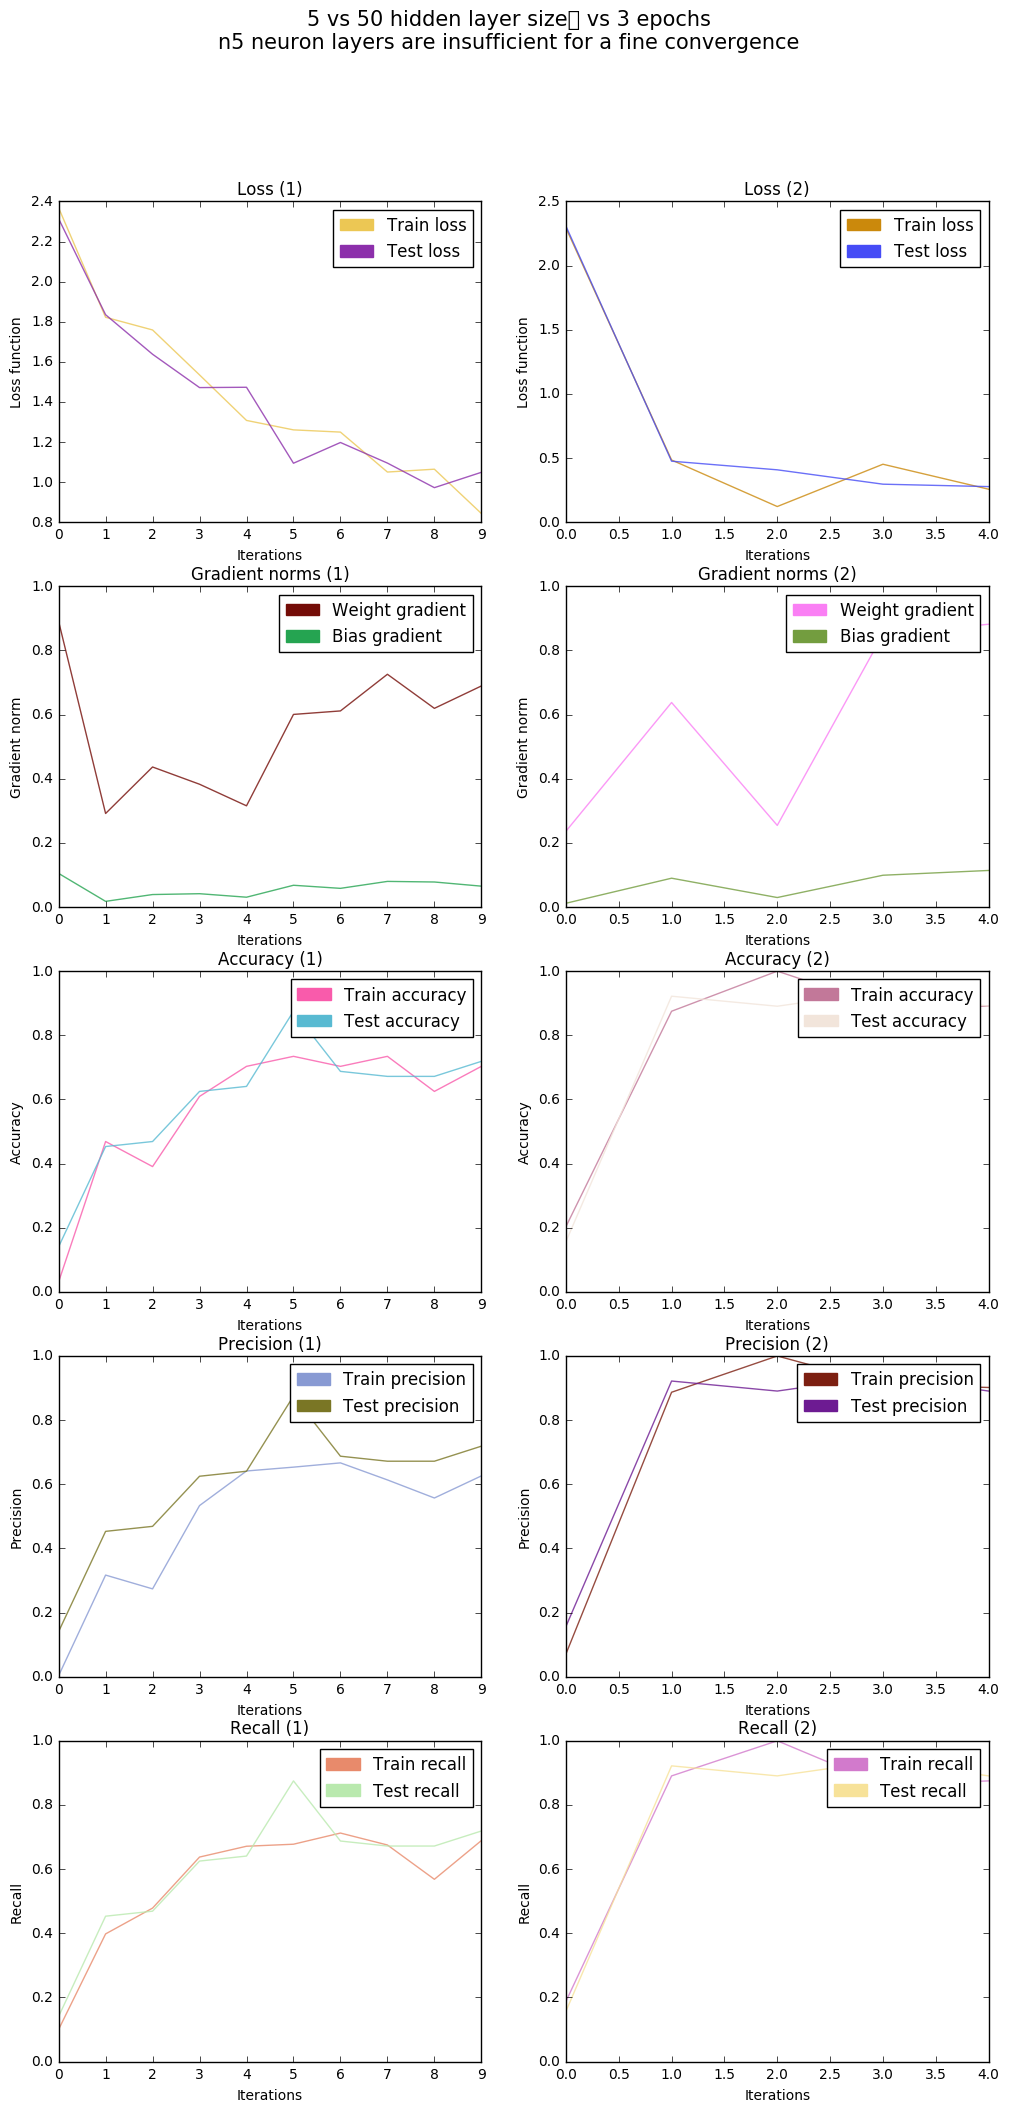

In [51]:
plot(losses1, losses2, norms1, norms2, acc1, acc2, prec1, prec2, rec1, rec2,
     "5 vs 50 hidden layer size\10 vs 3 epochs\nn5 neuron layers are insufficient for a fine convergence")

In [33]:
losses1, norms1, acc1, prec1, rec1 = train(train_data, train_labels, test_data, test_labels, layers = 2, hdim = 50,
                        activation = torch.nn.Tanh, criterion = torch.nn.CrossEntropyLoss, biases = True)

100%|██████████| 938/938 [00:02<00:00, 359.28it/s]


In [34]:
losses2, norms2, acc2, prec2, rec2 = train(train_data, train_labels, test_data, test_labels, layers = 2, hdim = 50,
                        activation = torch.nn.Tanh, criterion = torch.nn.MSELoss, biases = True)

100%|██████████| 938/938 [00:01<00:00, 608.86it/s]


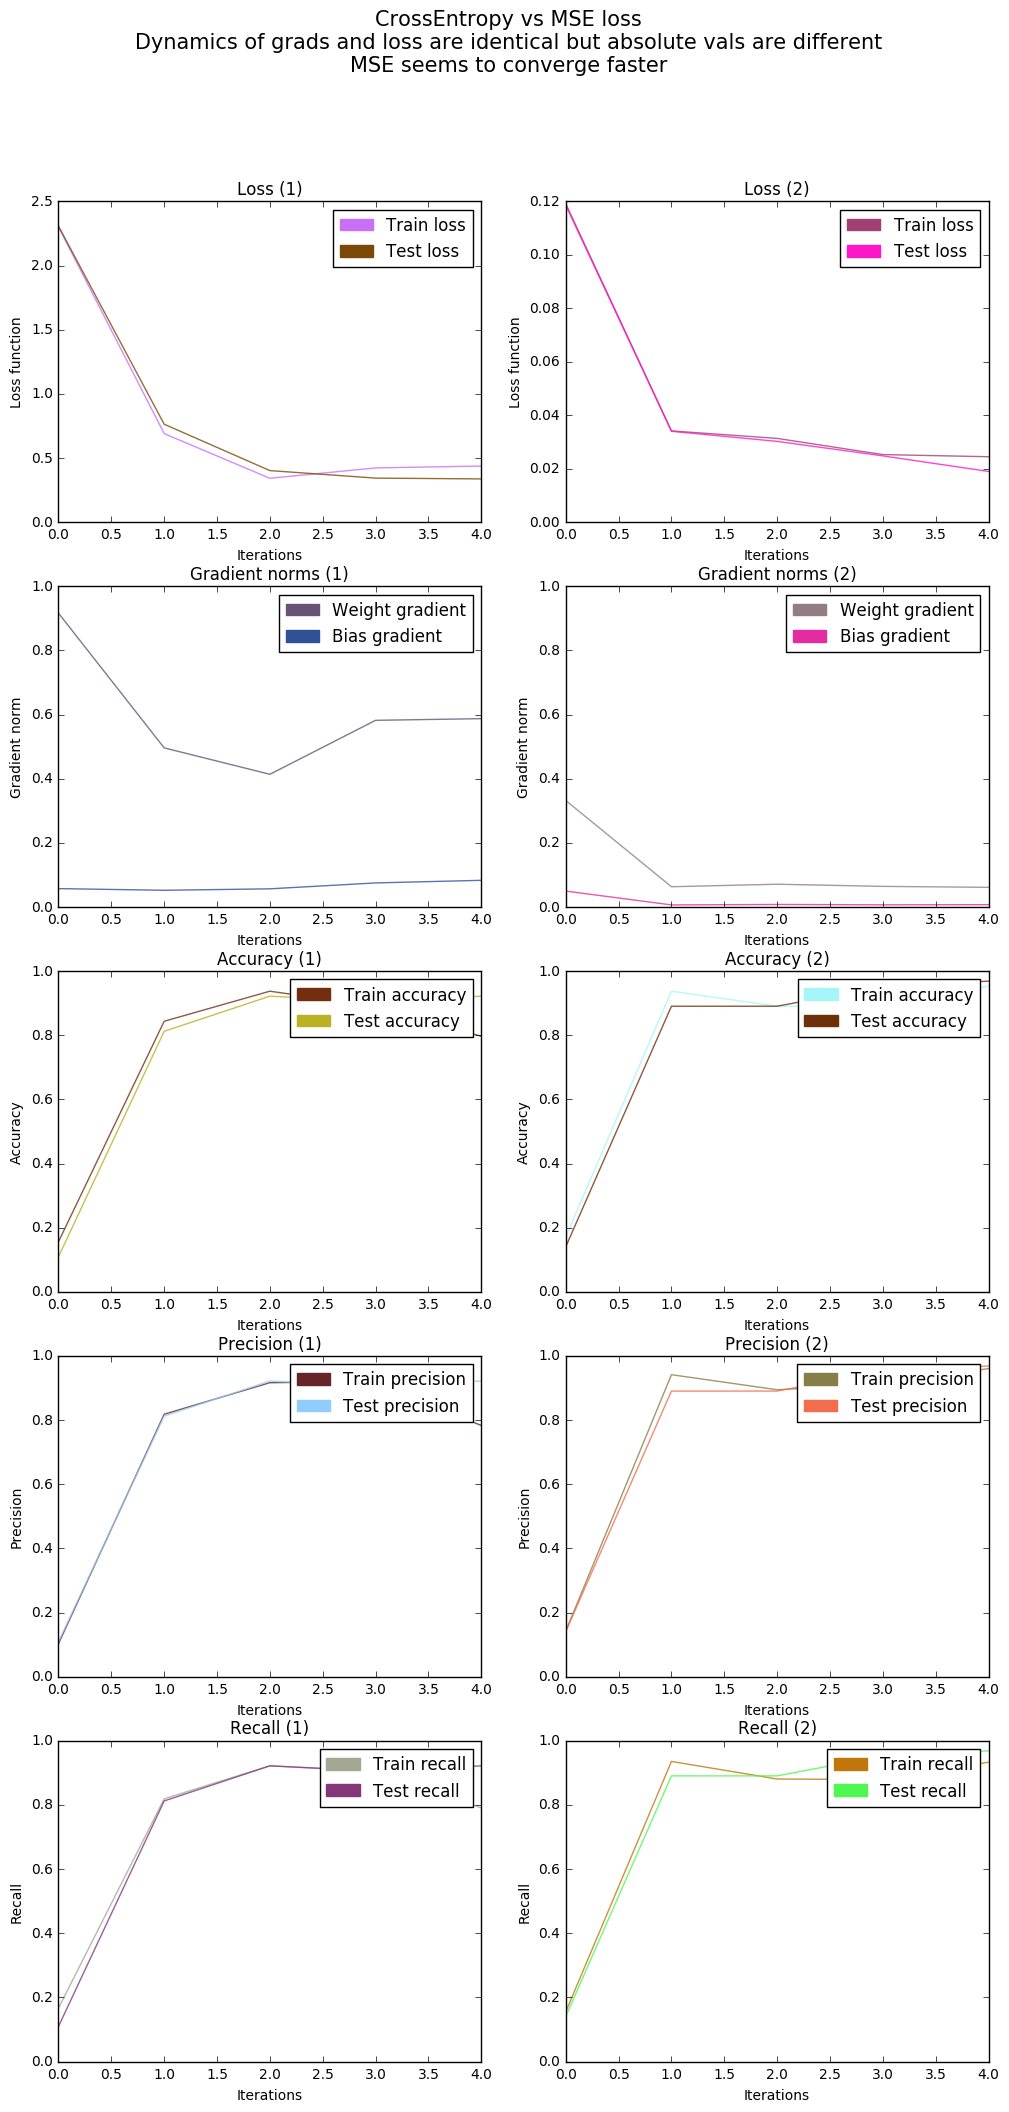

In [37]:
plot(losses1, losses2, norms1, norms2, acc1, acc2, prec1, prec2, rec1, rec2,
     "CrossEntropy vs MSE loss\nDynamics of grads and loss are identical but absolute vals are different\nMSE seems to converge faster")

In [41]:
losses1, norms1, acc1, prec1, rec1 = train(train_data, train_labels, test_data, test_labels, layers = 2, hdim = 50,
                        activation = torch.nn.ReLU, criterion = torch.nn.CrossEntropyLoss, biases = True)

losses2, norms2, acc2, prec2, rec2 = train(train_data, train_labels, test_data, test_labels, layers = 2, hdim = 50,
                        activation = torch.nn.ReLU, criterion = torch.nn.CrossEntropyLoss, biases = False)

100%|██████████| 938/938 [00:02<00:00, 400.17it/s]


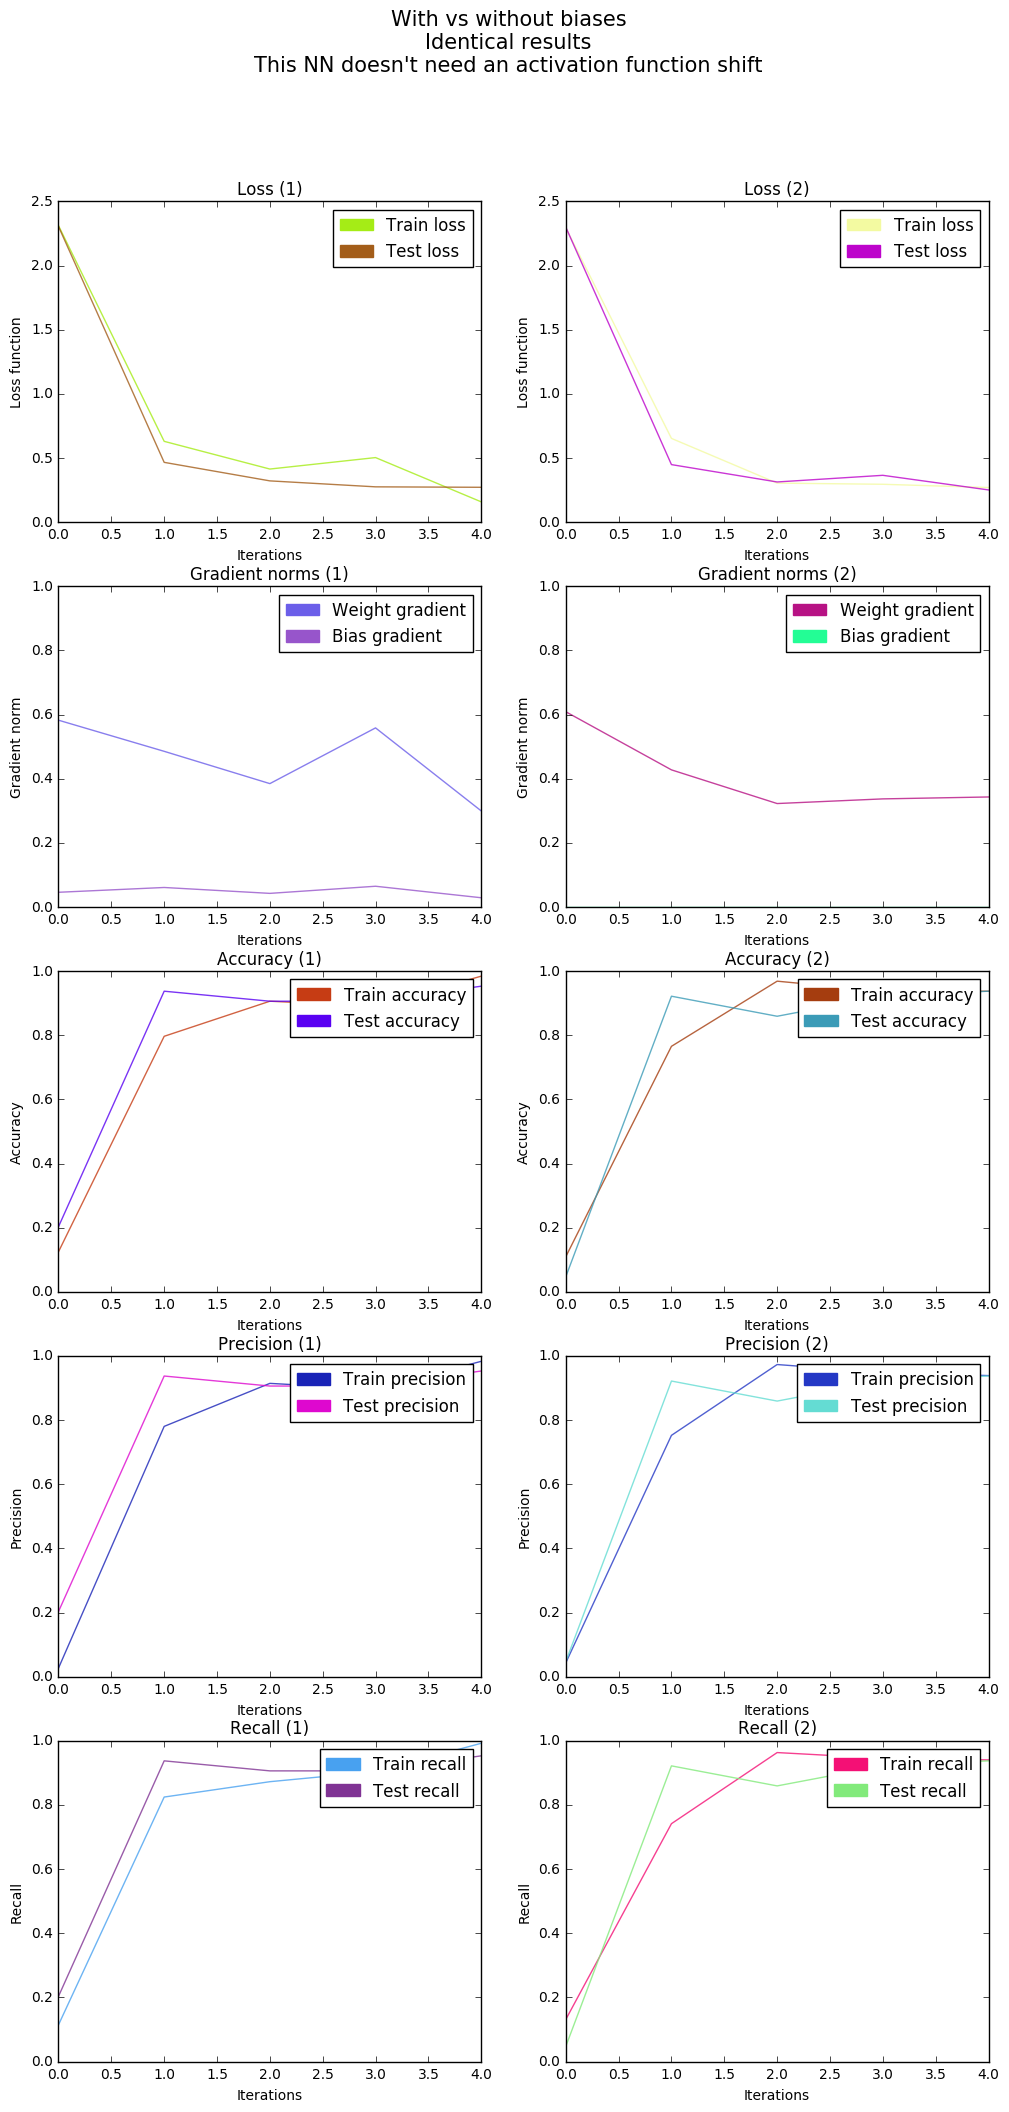

In [42]:
plot(losses1, losses2, norms1, norms2, acc1, acc2, prec1, prec2, rec1, rec2,
     "With vs without biases\nIdentical results\nThis NN doesn't need an activation function shift")

In [44]:
losses1, norms1, acc1, prec1, rec1 = train(train_data, train_labels, test_data, test_labels, layers = 3, hdim = 50,
                        activation = torch.nn.Tanh, criterion = torch.nn.CrossEntropyLoss, biases = True)

losses2, norms2, acc2, prec2, rec2 = train(train_data, train_labels, test_data, test_labels, layers = 3, hdim = 50,
                        activation = torch.nn.ReLU, criterion = torch.nn.CrossEntropyLoss, biases = True)

100%|██████████| 938/938 [00:03<00:00, 256.44it/s]


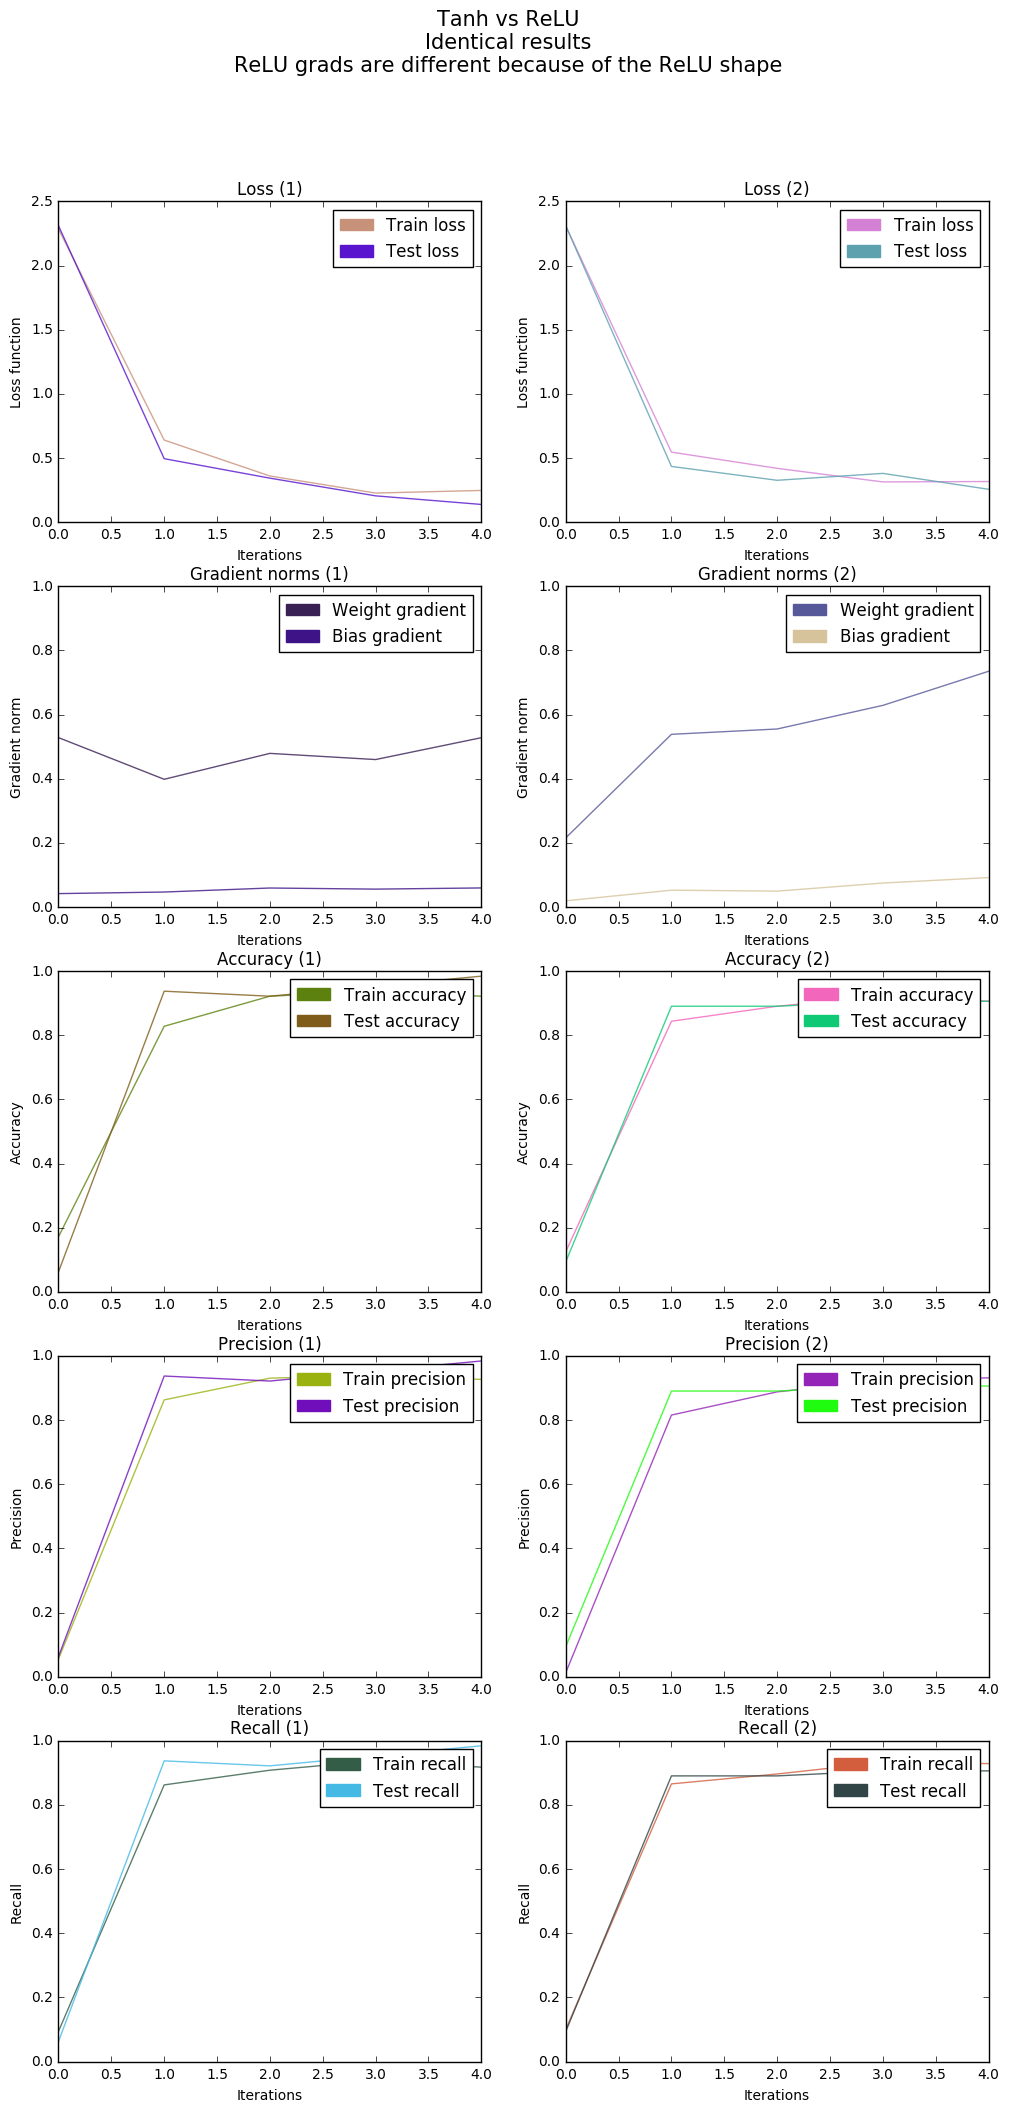

In [45]:
plot(losses1, losses2, norms1, norms2, acc1, acc2, prec1, prec2, rec1, rec2,
     "Tanh vs ReLU\nIdentical results\nReLU grads are different because of the ReLU shape")

In [46]:
losses1, norms1, acc1, prec1, rec1 = train(train_data, train_labels, test_data, test_labels, layers = 3, hdim = 50,
                        activation = torch.nn.Tanh, criterion = torch.nn.CrossEntropyLoss, biases = True)

losses2, norms2, acc2, prec2, rec2 = train(train_data, train_labels, test_data, test_labels, layers = 3, hdim = 50,
                        activation = torch.nn.Sigmoid, criterion = torch.nn.CrossEntropyLoss, biases = True, epochs = 10)

100%|██████████| 938/938 [00:03<00:00, 290.06it/s]


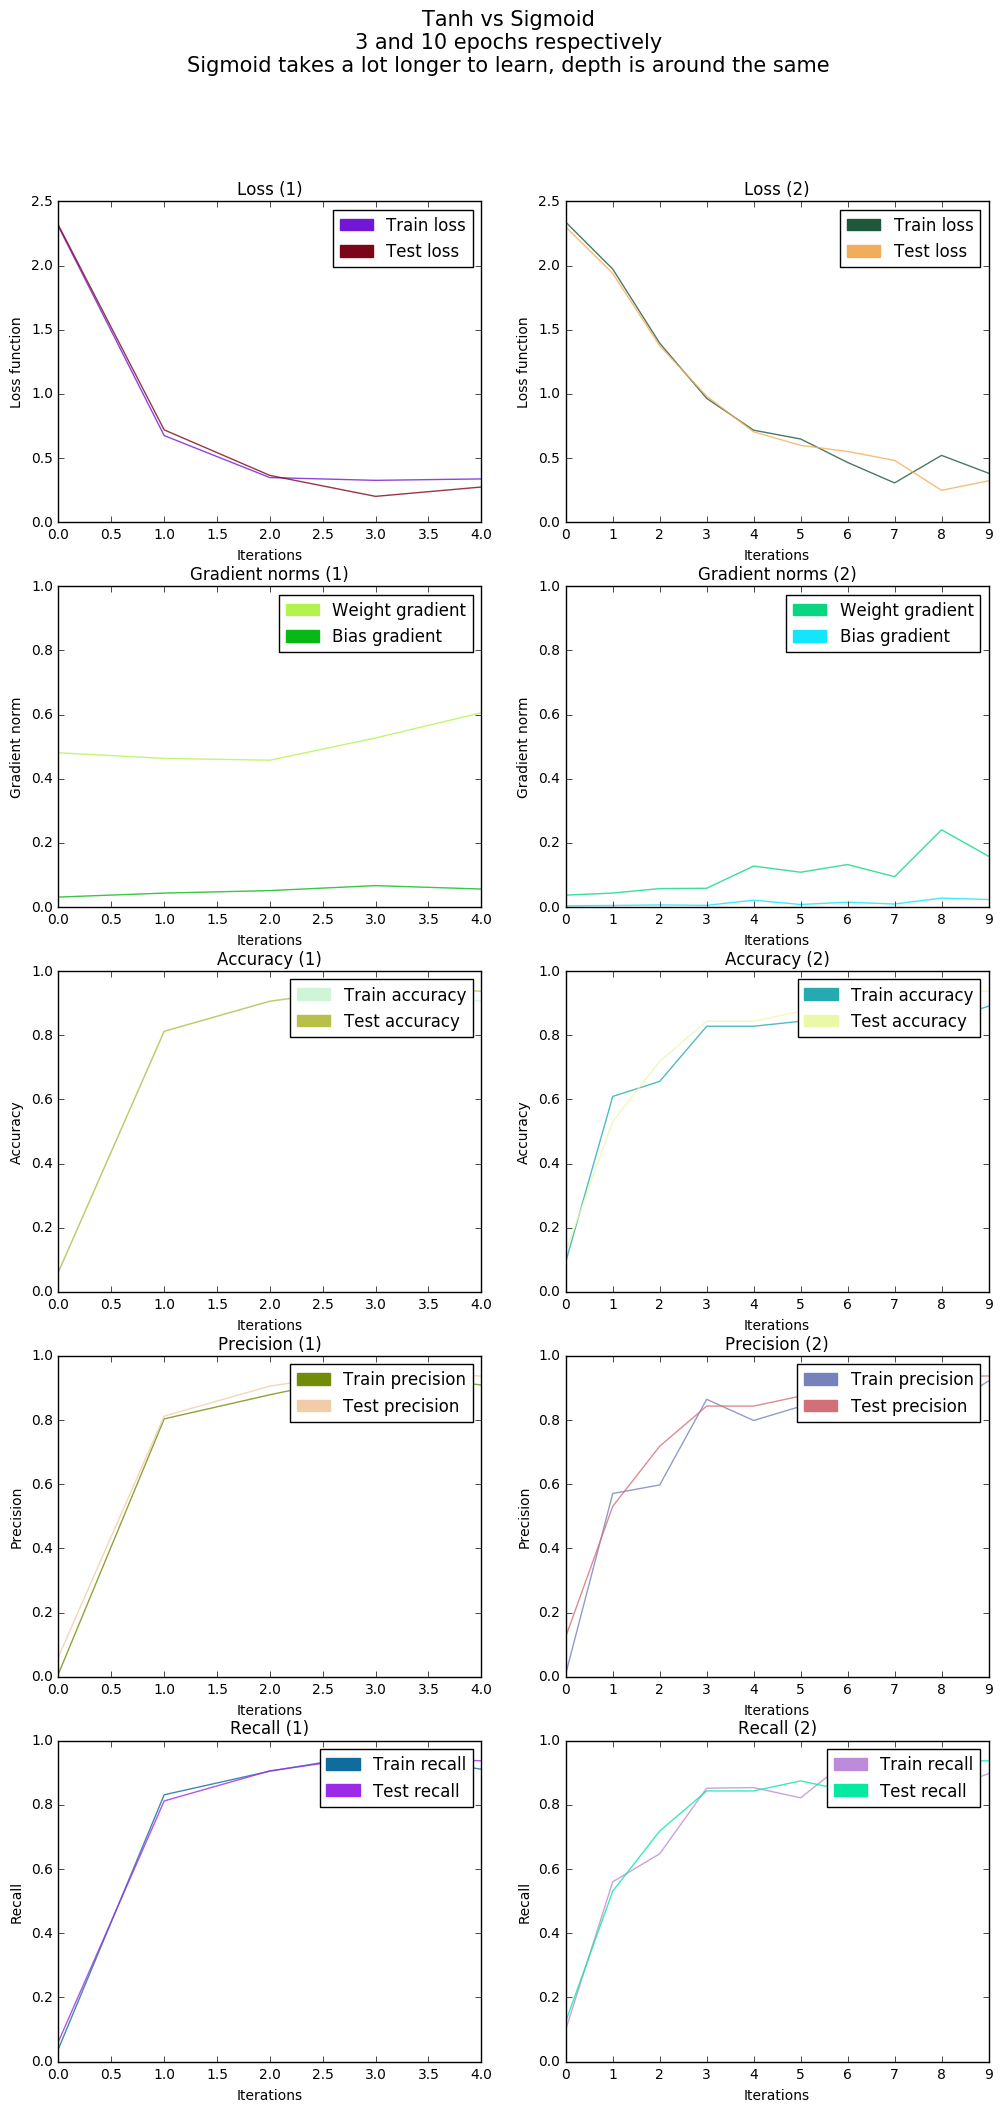

In [47]:
plot(losses1, losses2, norms1, norms2, acc1, acc2, prec1, prec2, rec1, rec2,
     "Tanh vs Sigmoid\n3 and 10 epochs respectively\nSigmoid takes a lot longer to learn, depth is around the same")

In [48]:
losses1, norms1, acc1, prec1, rec1 = train(train_data, train_labels, test_data, test_labels, layers = 1, hdim = 50,
                        activation = torch.nn.Tanh, criterion = torch.nn.CrossEntropyLoss, biases = True)

losses2, norms2, acc2, prec2, rec2 = train(train_data, train_labels, test_data, test_labels, layers = 4, hdim = 50,
                        activation = torch.nn.Tanh, criterion = torch.nn.CrossEntropyLoss, biases = True)

100%|██████████| 938/938 [00:04<00:00, 230.45it/s]


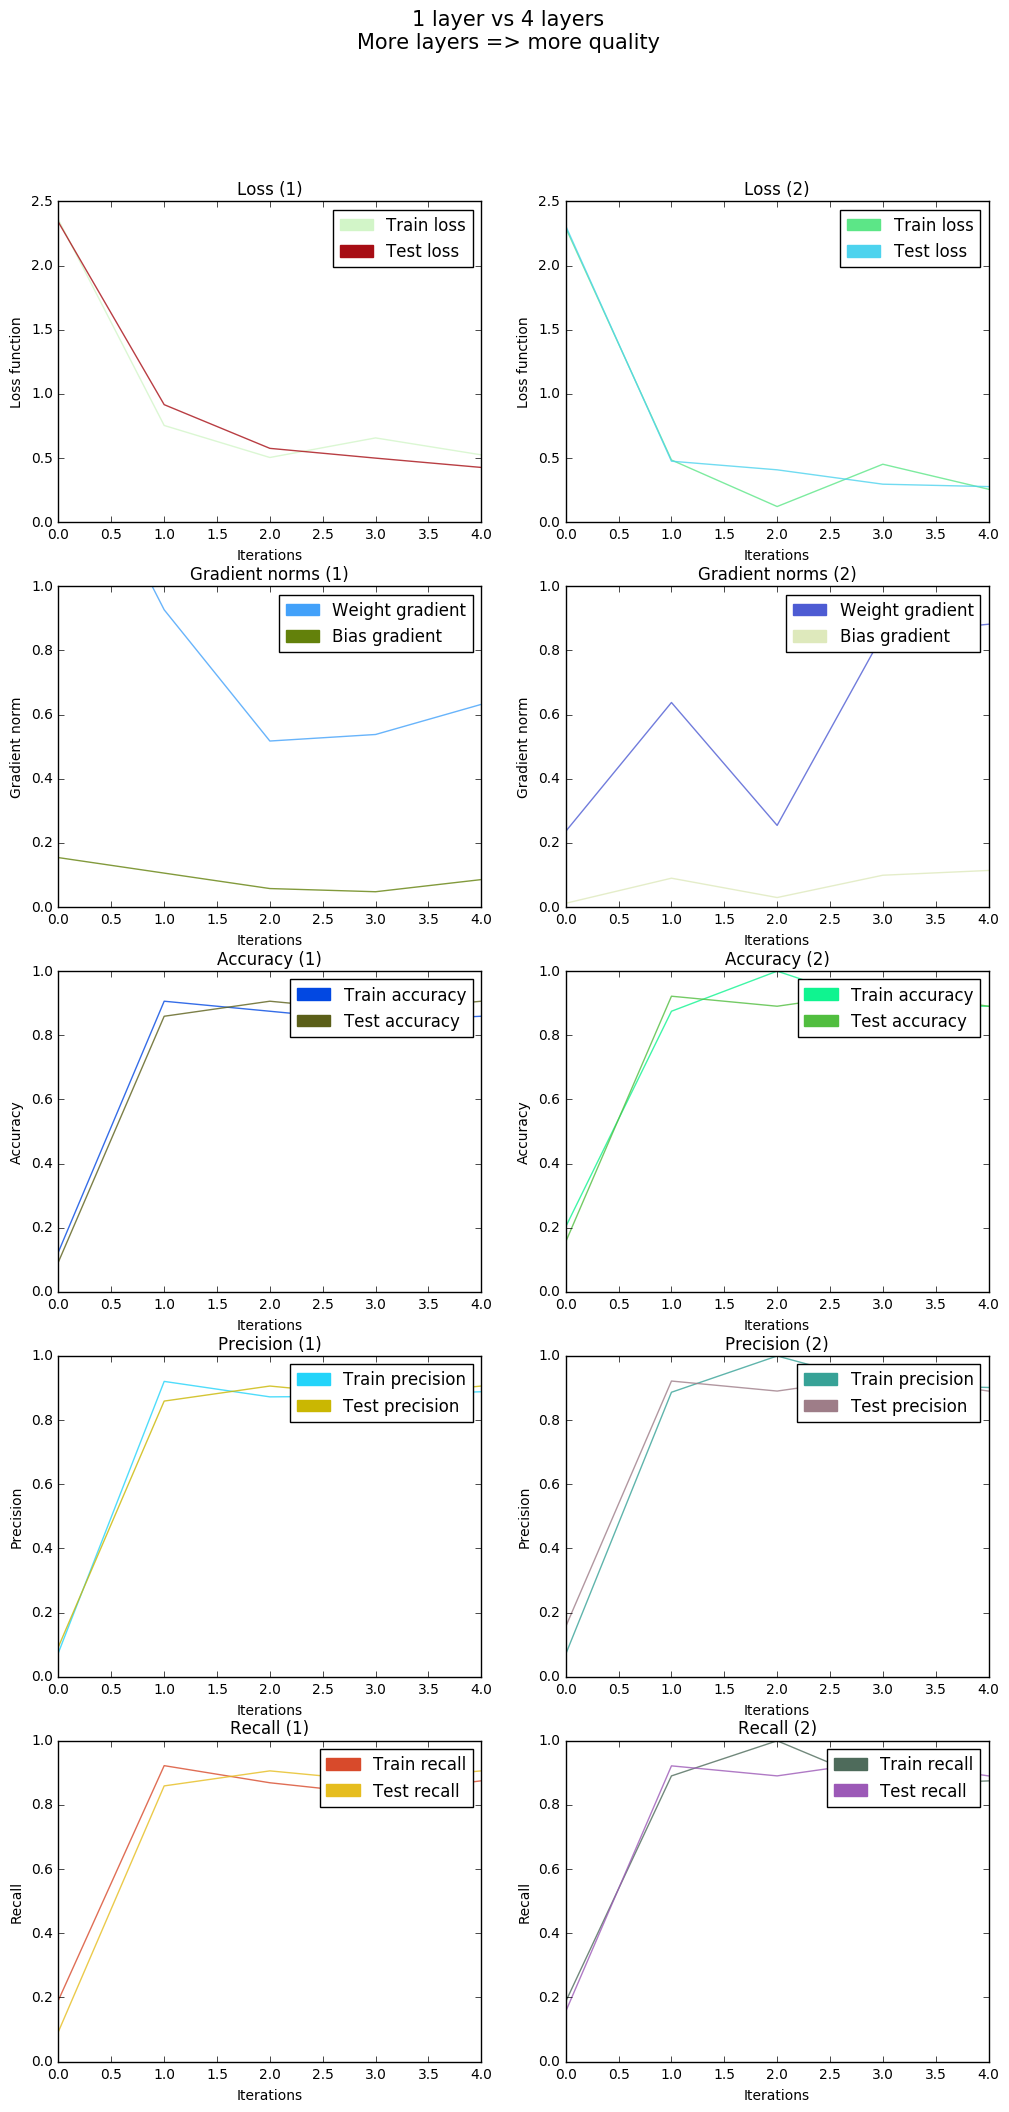

In [49]:
plot(losses1, losses2, norms1, norms2, acc1, acc2, prec1, prec2, rec1, rec2,
     "1 layer vs 4 layers\nMore layers => more quality")